In [1]:
import pandas as pd
from sklearn import preprocessing
import sklearn.model_selection as ms
from sklearn import linear_model
import sklearn.metrics as sklm
import numpy as np
import numpy.random as nr
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
import math

%matplotlib inline

In [2]:
## Load Data
auto_prices = pd.read_csv('Auto_Data_Preped.csv')
# auto_prices.columns
auto_prices.head()
auto_prices.shape

(195, 26)

In [7]:
## Create dummy variables from categorical features
'''
print(auto_prices['body_style'].unique())
Features = auto_prices['body_style']
enc = preprocessing.LabelEncoder()  # an encoder object is created
enc.fit(Features)  # give unique string values of the features
Features = enc.transform(Features)  # applies the numeric encoding to the original feature
print(Features)

# the numerically coded categorical variable is converted to a set of dummy variables
ohe = preprocessing.OneHotEncoder()
# the numerically coded categorical feature is fit with the one hot encoder
encoded = ohe.fit(Features.reshape(-1,1))  
Features = encoded.transform(Features.reshape(-1,1)).toarray()
print(Features[:10,:])
'''

def encode_string(cat_feature):
    ## First encode the strings to numeric categories
    enc = preprocessing.LabelEncoder()
    enc.fit(cat_feature)
    enc_cat_feature = enc.transform(cat_feature)
    ## apply one hot encoding
    ohe = preprocessing.OneHotEncoder()
    # -1 means an unknown dimension; using reshape(-1,1), if your data has a single feature
    encoded = ohe.fit(enc_cat_feature.reshape(-1,1)) 
    return encoded.transform(enc_cat_feature.reshape(-1,1)).toarray()
    

categorical_columns = ['body_style', 'fuel_type', 'aspiration', 'drive_wheels', 'num_of_cylinders']
Features = np.zeros((auto_prices.shape[0],1))

for col in categorical_columns:
    temp = encode_string(auto_prices[col])
    Features = np.concatenate([Features, temp], axis = 1)
    
## Add numeric features
Features = np.concatenate([Features, np.array(auto_prices[['curb_weight', 'horsepower', 'city_mpg']])], axis = 1)
Features = np.delete(Features, 0, axis=1)  # delete the first empty column

(195, 1)
(195, 4)
(195, 2)
(195, 2)
(195, 3)
(195, 3)
(195, 18)
(195, 17)


In [29]:
## Randomly sample cases to create independent training and test data
nr.seed(9988)
labels = np.array(auto_prices['log_price'])
indx = range(Features.shape[0])  # counting of observations
indx = ms.train_test_split(indx, test_size = 40)
# print(len(indx[0]),len(indx[1]))

x_train = Features[indx[0],:]  # indx[0]: the observation numbers for train set
y_train = np.ravel(labels[indx[0]])

x_test = Features[indx[1],:]  # indx[1]: the observation numbers for test set
y_test = np.ravel(labels[indx[1]])


## Rescale numeric features
# scaler is fit only on the training data
scaler = preprocessing.StandardScaler().fit(x_train[:,14:])  # numeric features are the last three columns
x_train[:,14:] = scaler.transform(x_train[:,14:])  
x_test[:,14:] = scaler.transform(x_test[:,14:])
# print(x_train.shape, x_train[0,:])

(155, 17) [ 0.          0.          1.          0.          1.          0.
  1.          0.          0.          1.          0.          0.
  0.          1.         -0.5384069  -1.26225437  1.33602998]


In [30]:
## define and fit the linear regression model
lin_mod = linear_model.LinearRegression(fit_intercept = False)
lin_mod.fit(x_train, y_train)
print(lin_mod.intercept_)
print(lin_mod.coef_)

0.0
[ 1.36372345  1.15436725  1.27397827  1.16791069  2.57778903  2.38219063
  2.48184692  2.47813274  1.62299441  1.62646566  1.71051959  1.70397511
  1.71596353  1.54004103  0.18009827  0.14148126 -0.07296916]


In [31]:
## Evaluate the model
def print_metrics(y_true, y_predicted, n_parameters):
    ## First compute R^2 and the adjusted R^2
    r2 = sklm.r2_score(y_true, y_predicted)
    r2_adj = r2 - (n_parameters - 1)/(y_true.shape[0] - n_parameters) * (1 - r2)
    
    ## Print the usual metrics and the R^2 values
    print('Mean Square Error      = ' + str(sklm.mean_squared_error(y_true, y_predicted)))
    print('Root Mean Square Error = ' + str(math.sqrt(sklm.mean_squared_error(y_true, y_predicted))))
    print('Mean Absolute Error    = ' + str(sklm.mean_absolute_error(y_true, y_predicted)))
    print('Median Absolute Error  = ' + str(sklm.median_absolute_error(y_true, y_predicted)))
    print('R^2                    = ' + str(r2))
    print('Adjusted R^2           = ' + str(r2_adj))
    
y_score = lin_mod.predict(x_test) 
print_metrics(y_test, y_score, 28) 

Mean Square Error      = 0.022616207744398355
Root Mean Square Error = 0.15038686027841114
Mean Absolute Error    = 0.11912678436796123
Median Absolute Error  = 0.10696449432930599
R^2                    = 0.9216386321026064
Adjusted R^2           = 0.7453255543334709


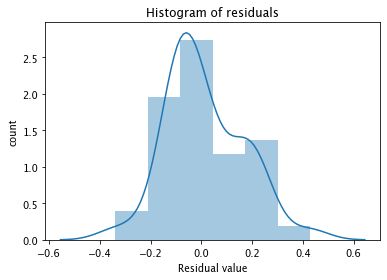

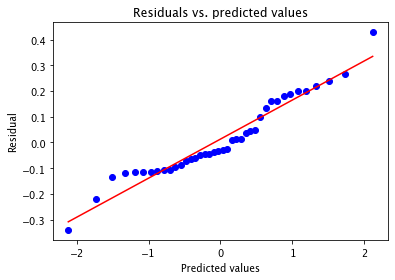

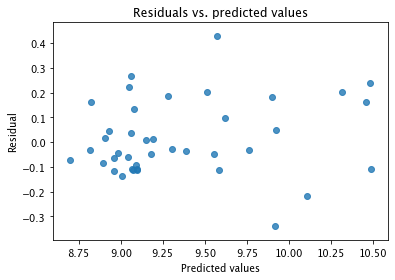

In [33]:
def hist_resids(y_test, y_score):
    ## first compute vector of residuals. 
    resids = np.subtract(y_test.reshape(-1,1), y_score.reshape(-1,1))
    ## now make the residual plots
    sns.distplot(resids)
    plt.title('Histogram of residuals')
    plt.xlabel('Residual value')
    plt.ylabel('count') 
    plt.show()

def resid_qq(y_test, y_score):
    ## first compute vector of residuals. 
    resids = np.subtract(y_test.reshape(-1,1), y_score.reshape(-1,1))
    ## now make the residual plots
    ss.probplot(resids.flatten(), plot = plt)
    plt.title('Residuals vs. predicted values')
    plt.xlabel('Predicted values')
    plt.ylabel('Residual') 
    plt.show()

def resid_plot(y_test, y_score):
    ## first compute vector of residuals. 
    resids = np.subtract(y_test.reshape(-1,1), y_score.reshape(-1,1))
    ## now make the residual plots
    sns.regplot(y_score, resids, fit_reg=False)
    plt.title('Residuals vs. predicted values')
    plt.xlabel('Predicted values')
    plt.ylabel('Residual')
    plt.show()
    
hist_resids(y_test, y_score) 

resid_qq(y_test, y_score) 

resid_plot(y_test, y_score) 
# The residual values appear to have a fairly constant dispersion as the predicted value changes. 
# A few large residuals are noticeable, particularly on the positive side.

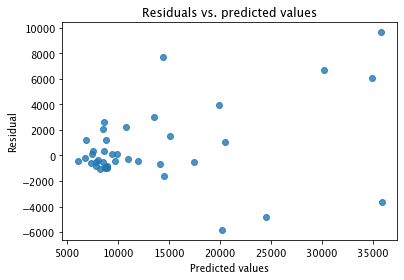

In [34]:
y_score_untransform = np.exp(y_score)
y_test_untransform = np.exp(y_test)
resid_plot(y_test_untransform, y_score_untransform) 
# The dispersion of the residuals has a cone-like pattern increasing to the right. 
# The regression model seems to do a good job of predicting the price of low cost cars, 
# but becomes progressively worse as the price of the car increases.

## Summary

The process of constructing and evaluating a multiple linear regression model:   
1. Transformed the label value to make it more symmetric and closer to a Normal distribution.
2. Aggregated categories of a categorical variable to improve the statistical representation. 
3. Scaled the numeric features. 
4. Recoded the categorical features as binary dummy variables. 
5. Fit the linear regression model using scikit-learn. 
6. Evaluated the performance of the model using both numeric and graphical methods. 